# Biblioteki

In [28]:
defaultW <- getOption("warn") 

options(warn = -1) 

install.packages('lubridate')
install.packages('sqldf')
install.packages('fastDummies')
install.packages("dplyr")
install.packages("ggplot2")
install.packages('maps')


library(lubridate)
library(sqldf)
library(maps)
library(fastDummies)
library(dplyr)
library(ggplot2)

# Funkcje

In [34]:
'%!in%' <- function(x, y)
  ! ('%in%'(x, y))

# Wczytywanie danych

## Attrition_dataset

In [35]:
dane <- read.csv(
    'Attrition_dataset.csv',
    header = T,
    sep = ';',
    na.strings = ''
  )
head(dane) 

,Emp_ID,MMM.YY,Age,Salary,LastWorkingDate,Designation,Total.Business.Value,Quarterly.Rating,Gender,City,Education_Level,Dateofjoining,Joining.Designation
,<int>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,01.01.2016,28,"57387,00 USD",NA,1,2381060,2,Male,C23,MASTER,24.12.2015,1
2,1,01.02.2016,28,"57387,00 USD",NA,1,-665480,2,Male,C23,MASTER,24.12.2015,1
3,1,01.03.2016,28,"57387,00 USD",11.03.2016,1,0,2,Male,C23,MASTER,24.12.2015,1
4,2,01.11.2017,31,"67016,00 USD",NA,2,0,1,Male,C7,Master,06.11.2017,2
5,2,01.12.2017,31,"67016,00 USD",NA,2,0,1,Male,C7,Master,06.11.2017,2
6,4,01.12.2016,43,"65603,00 USD",NA,2,0,1,Male,C13,Master,07.12.2016,2


```
Wczytany plik o nazwie "Attrition_dataset.csv" dotyczy danych o ocenach miesięcznych pracowników z działu sprzedaży ubezpieczeń do nowych klientów, które opisane są poprzez 13 zmiennych:

- MMM.YY - dzień wpisania oceny miesięcznej pracownika do bazy
- Emp_ID - identyfikator pracownika
- Age - wiek
- Gender - płeć
- City - identyfikator dla oddziału mieszczącego się w danym mieście
- Education_Level - wykształcenie z podziałem na Bachelor / College / Master
- Salary - wynagrodzenie roczne
- Dateofjoining - data dołączenia do firmy
- LastWorkingDate - data odejścia, jeśli pracownik odszedł w danym okresie
- Joining.Designation - pięciostopniowy poziom kwalifikacji podczas rekrutacji (1 - niski, 5 - bardzo wysoki)
- Designation - aktualny poziom kwalifikacji
- Total.Business.Value - sumaryczna ilość sprzedanych ubezpieczeń
- Quarterly.Rating - ocena roczna (1 - niski poziom, 5 bardzo wysoki poziom)


```

## Cities_map

In [36]:
miasta <- read.csv(
  'Cities_map.csv',
  header = T,
  sep = ';',
  na.strings = ''
)
head(miasta)

,City_ID,City_Name
,<chr>,<chr>
1,C01,Austin
2,C02,Boston
3,C03,Charlotte
4,C04,Chicago
5,C05,Columbus
6,C06,Dallas


```
Kolejny plik ("Cities_map.csv") odpowiada za identyfikatory miast występujących w pliku "Attrition_dataset.csv" w 
kolumnie City. Wymienionych zostało 29 miast, a każdy z nich posiada swój unikatowy symbol.
```

# Czyszczenie danych

```
Otrzymane dane należy poddać dokładnej analizie. Wpierw jednak należy sprawdzić oraz ewentualnie oczyścić dane z 
wszelkich błędów, bądź wartości niezgodnych z resztą rekordów. Stwórzmy więc dodatkowe zmienne, które będą 
przechowywały nasze rekordy przeznaczone do transformacji.
```

In [37]:
miasta_czyste <- miasta
dane_czyste <- dane
miasta_czyste[1:9, 1] <- gsub('0', '', miasta[1:9, 1])

## Wykształcenie

```
W kolumnie Educational_Level dotyczącym poziomu wykształcenia pracownika występowały nieprawidłowo sformatowane 
nazwy poziomów, powodujące problem przy segregacji na trzy konkretne poziomy: "Bachelor", "Master" oraz "College".
Należało wyszukać błędnie wprowadzone rekordy, a następnie zastąpić je prawidłowym parametrem.
```

In [38]:
wyksztalcenie <- unique(dane$Education_Level)

dane_czyste$Education_Level <-
  ifelse(
    dane$Education_Level == "Bachelor's",
    'Bachelor',
    ifelse(
      dane$Education_Level == 'MASTER',
      'Master',
      ifelse(
        dane$Education_Level == 'Colege',
        'College',
        dane$Education_Level
      )
    )
  )

## Daty

```
Kolumna MMM.YY również posiadała niezgodne formaty dat. Utrudniało to zdecydowanie ocenę czasu pracy zatrudnionych, 
dlatego też zastosowano jednakowy format dla wszystkich dat.
```

In [39]:
dane_czyste$MMM.YY <- as.Date(dane$MMM.YY, format = '%d.%m.%Y')
dane_czyste$LastWorkingDate <-
  as.Date(dane$LastWorkingDate, format = '%d.%m.%Y')

## Daty dołączenia

```
Przeprowadzono poszukiwania problematycznych dat w celu korygania błędów. Niektóre dane posiadały miesiące w odmiennym 
formacie, tak więc zastosowano modyfikację.
```

In [40]:
data_dolaczenia <- dane$Dateofjoining
y <- unique(dane$Dateofjoining[grep('August', data_dolaczenia)])
y_ <- unique(dane$Dateofjoining[grep('Oct', dane$Dateofjoining)])
daty_problematyczne <- c(y, y_)
daty_zmienione <-
  c(
    '06.08.2012',
    '13.08.2012',
    '02.08.2012',
    '09.08.2012',
    '07.08.2012',
    '16.10.2018',
    '16.10.2014',
    '16.10.2019',
    '16.10.2021',
    '16.10.2017'
  )
for (i in 1:length(daty_problematyczne))
{
  dane_czyste$Dateofjoining <-
    ifelse(
      dane$Dateofjoining == daty_problematyczne[i],
      daty_zmienione[i],
      dane_czyste$Dateofjoining
    )
}
dane_czyste$Dateofjoining <-
  as.Date(dane_czyste$Dateofjoining, format = "%d.%m.%Y")

## Zarobki

``` 
Wartości odpowiadające za zarobki pracowników zostały przekształcone poprzez formatowanie na wersję numeryczną oraz 
usunięto walutę dla ułatwienia rachunków oraz podsumowań.
```

In [41]:
zarobki <-  gsub(' USD', '' , dane$Salary)
dane_czyste$Salary <- as.numeric(gsub(',', '.', zarobki))

## Płeć (1 - mężczyzna, 0 - kobieta)

``` 
Płeć pracowników, wstępnie przedstawiona w formie tekstowej, zastąpiono liczbami: 1 dla mężczyzny oraz 0 dla kobiety.
```

In [42]:
dane_czyste$Gender <- ifelse(dane$Gender == 'Male', 1, 0)

## Czy dany pracownik odszedł?

``` 
Po przeprowadzniu zmian z formatowaniem dat, wprowadzono dodatkową kolumnę informującą o aktualnej sytuacji pracownika - 
mianowicie czy opuścił firmę czy też nadal w niej pracuje.
```

In [43]:
odchodzacy <-
  dane_czyste[!is.na(dane$LastWorkingDate), c("Emp_ID", "LastWorkingDate", "Dateofjoining")]
odchodzacy$staz <-
  difftime(odchodzacy$LastWorkingDate, odchodzacy$Dateofjoining, units = "days")
names(odchodzacy)[1] <- "ID"
odchodzacy$flaga <- 1

do_laczenia <- odchodzacy[, c("staz", "flaga", "ID")]
do_laczenia$staz <- as.numeric(do_laczenia$staz)

In [44]:
str(dane_czyste)

'data.frame':	19190 obs. of  13 variables:
 $ Emp_ID              : int  1 1 1 2 2 4 4 4 4 4 ...
 $ MMM.YY              : Date, format: "2016-01-01" "2016-02-01" ...
 $ Age                 : int  28 28 28 31 31 43 43 43 43 43 ...
 $ Salary              : num  57387 57387 57387 67016 67016 ...
 $ LastWorkingDate     : Date, format: NA NA ...
 $ Designation         : int  1 1 1 2 2 2 2 2 2 2 ...
 $ Total.Business.Value: int  2381060 -665480 0 0 0 0 0 0 350000 0 ...
 $ Quarterly.Rating    : int  2 2 2 1 1 1 1 1 1 1 ...
 $ Gender              : num  1 1 1 1 1 1 1 1 1 1 ...
 $ City                : chr  "C23" "C23" "C23" "C7" ...
 $ Education_Level     : chr  "Master" "Master" "Master" "Master" ...
 $ Dateofjoining       : Date, format: "2015-12-24" "2015-12-24" ...
 $ Joining.Designation : int  1 1 1 2 2 2 2 2 2 2 ...


# Łączenie danych

``` 
Dokładna analiza naszych danych będzie możliwa dzięki połączeniu obu tabel "Attrition_dataset.csv" oraz "Cities_map.csv"
poprzez identyfikatory miast. Ułatwi to nam ustalić miejsce zamieszkania naszych pracowników.
```

In [45]:
zlaczone <-
  sqldf('SELECT * FROM dane_czyste left join miasta_czyste on City = City_ID')

zlaczone <-
  dummy_cols(
    .data = zlaczone,
    select_columns = c("Education_Level", "City_Name"),
    ignore_na = T
  )

wyczyszczone <-
  zlaczone[zlaczone$Emp_ID %!in% (odchodzacy$ID[odchodzacy$staz == 0 |
                                                  odchodzacy$staz < 0]), ]
odchodzacy_bez_bledow <- odchodzacy[odchodzacy$staz > 0, ]
odchodzacy_bez_bledow$staz_numerycznie <-
  as.numeric(odchodzacy_bez_bledow$staz)
wyczyszczone <- distinct(wyczyszczone)

wyczyszczone_z_flaga <-
  sqldf('SELECT * FROM wyczyszczone as w left join do_laczenia as d on w.Emp_ID = d.ID')
wyczyszczone_z_flaga$ID <- NULL
wyczyszczone_z_flaga$flaga <-
  ifelse(is.na(wyczyszczone_z_flaga$flaga), 0, 1)
wyczyszczone_z_flaga$staz <-
  ifelse(
    is.na(wyczyszczone_z_flaga$staz),
    as.numeric(
      difftime(today(), wyczyszczone_z_flaga$Dateofjoining, units = "days")
    ),
    wyczyszczone_z_flaga$staz
  )

# Zapisanie wyczyszczonych danych

```
Ostatecznie przekształcone dane zapisujemy w dwóch osobnych plikach: 
- dane które zostały oczyszczone
- dane dotyczące pracowników, którzy opuścili swoje miejsce pracy
```

In [46]:
write.csv(x = wyczyszczone_z_flaga,
          file = "zbior_danych_czysty.csv",
          row.names = F)
write.csv(x = odchodzacy_bez_bledow,
          file = "pracowinicy_ktorzy_odeszli.csv",
          row.names = F)

# Analiza

```
Następnie załadujmy nasze nowo utworzone pliki .csv, by przeprowadzić dalszy ciąg badania.
```

In [47]:
odeszli <-
  read.csv(
    'pracowinicy_ktorzy_odeszli.csv',
    header = T,
    sep = ',',
    na.strings = ''
)
head(odeszli)

,ID,LastWorkingDate,Dateofjoining,staz,flaga,staz_numerycznie
,<int>,<chr>,<chr>,<int>,<int>,<int>
1,1,2016-03-11,2015-12-24,78,1,78
2,4,2017-04-27,2016-12-07,141,1,141
3,5,2016-03-07,2016-01-09,58,1,58
4,8,2017-11-15,2017-09-19,57,1,57
5,12,2016-12-21,2016-06-29,175,1,175
6,13,2017-11-25,2012-05-28,2007,1,2007


In [48]:
dane1 <-   read.csv(
  'zbior_danych_czysty.csv',
  header = T,
  sep = ',',
  na.strings = ''
)
head(dane1)

,Emp_ID,MMM.YY,Age,Salary,LastWorkingDate,Designation,Total.Business.Value,Quarterly.Rating,Gender,City,...,City_Name_Phoenix,City_Name_Portland,City_Name_San.Antonio,City_Name_San.Diego,City_Name_San.Francisco,City_Name_San.Jose,City_Name_Seattle,City_Name_Washington,staz,flaga
,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,2016-01-01,28,57387,NA,1,2381060,2,1,C23,...,0,1,0,0,0,0,0,0,78,1
2,1,2016-02-01,28,57387,NA,1,-665480,2,1,C23,...,0,1,0,0,0,0,0,0,78,1
3,1,2016-03-01,28,57387,2016-03-11,1,0,2,1,C23,...,0,1,0,0,0,0,0,0,78,1
4,2,2017-11-01,31,67016,NA,2,0,1,1,C7,...,0,0,0,0,0,0,0,0,1616,0
5,2,2017-12-01,31,67016,NA,2,0,1,1,C7,...,0,0,0,0,0,0,0,0,1616,0
6,4,2016-12-01,43,65603,NA,2,0,1,1,C13,...,0,0,0,0,0,0,0,0,141,1


```
Dla lepszego przebiegu wizualizacji oraz analizy pozbędziemy się zduplikowanych rekordów, abyśmy mogli 
przedstawić pełne porównanie dla wszystkich pracowników bez względu na datę oceny danej osoby.
```

In [65]:
dane <- dane1
dane <- dane[,c("Emp_ID","flaga","Gender","City","Education_Level","Dateofjoining",
                "Joining.Designation","City_Name","staz")] 
dane <- distinct(dane) #usuniecie duplikatow
nrow(dane)

[1] 2372

```
Pozbycie się duplikatów zmniejszyło naszą ilość wierszy. Pozwaliło to również wyłonić liczbę pracowników, którzy
przebili się przez naszą firmę - na liście HR'ów jest ich 2372 osoby.
```

In [66]:
sredni_wiek <-aggregate(dane1$Age, 
                        by=list(dane1$Emp_ID), FUN=mean)

srednia_ocen_rocznych <-aggregate(dane1$Quarterly.Rating, 
                                  by=list(dane1$Emp_ID), FUN=mean)

srednia_kpi <-aggregate(dane1$Total.Business.Value, 
                                  by=list(dane1$Emp_ID), FUN=mean)

srednie_wynagrodzenie <-aggregate(dane1$Salary, 
                        by=list(dane1$Emp_ID), FUN=mean)

dane <- merge(dane, sredni_wiek,by.x="Emp_ID", by.y="Group.1")
dane <-rename(dane,sredni_wiek=x)
dane <- merge(dane, srednia_ocen_rocznych,by.x="Emp_ID", by.y="Group.1")
dane <-rename(dane,srednia_ocen_rocznych=x)
dane <- merge(dane, srednia_kpi,by.x="Emp_ID", by.y="Group.1")
dane <-rename(dane,srednia_kpi=x)
dane <- merge(dane, srednie_wynagrodzenie,by.x="Emp_ID", by.y="Group.1")
dane <-rename(dane,srednie_wynagrodzenie=x)

```
Rozdzielając naszych pracowników na tych, którzy odeszli oraz na tych, którzy nadal pracują w firmie ustalimy 
jaka jest obecna sytuacja w badanej spółce. Oznaczmy poprzez 1 osoby, które zrezygnowały z pracy w firmie, a 
poprzez 0 - osoby nadal zatrudnione.
```

In [67]:
dane$flaga <- ifelse(dane$flaga == 1,"rezygnacja","brak_rezygnacji")
table(dane$flaga)


brak_rezygnacji      rezygnacja 
            765            1607 

```
Wygenerowana tabela powyżej informuje o 1607 osobach, które zdążyły już opuścić biuro - jest to 68% całej populacji. 
Pozostałe 765 pracowników wciąż dzielnie wspomaga biznes naszej działalności. 

Wykres kolumnowy zamieszczony poniżej przedstawia opisany temat rezygnacji.
```

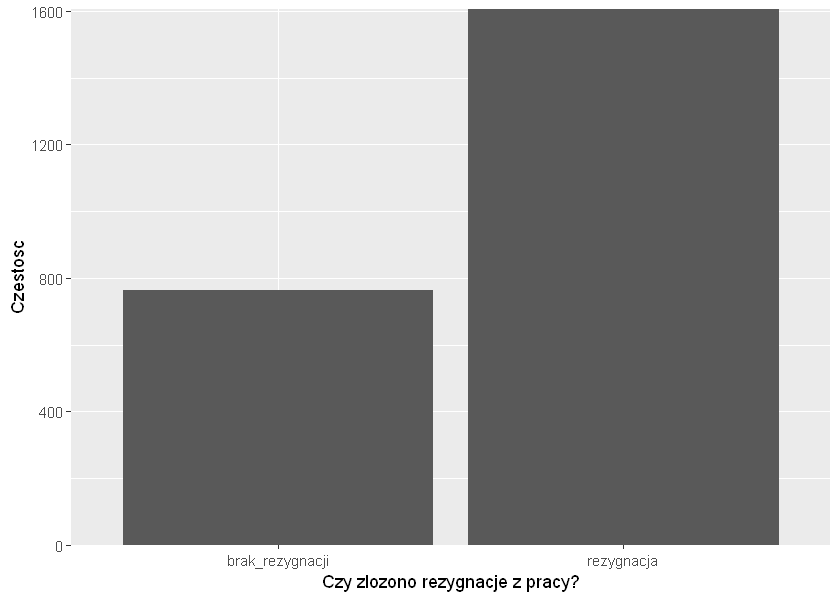

In [68]:
options(repr.plot.width=7, repr.plot.height=5)
ggplot(dane, aes(x = flaga)) +
  geom_bar() + 
  labs(x = "Czy zlozono rezygnacje z pracy?", y = "Czestosc") +
  scale_y_continuous(expand = c(0,0))

```
Kolejnym interesującym aspektem porównawczym naszych pracowników jest ich płeć. Pod 1 kryją się mężczyźni, 
natomiast 0 opisuje płeć piękną.
```

In [69]:
dane$Gender <- ifelse(dane$Gender == 1,"mezczyzna","kobieta")
table(dane$Gender)


  kobieta mezczyzna 
      973      1399 

```
Lista działu HR wykazuje przewagę liczby mężczyzn nad liczbą kobiet - ich różnica wynosi 30%.
```

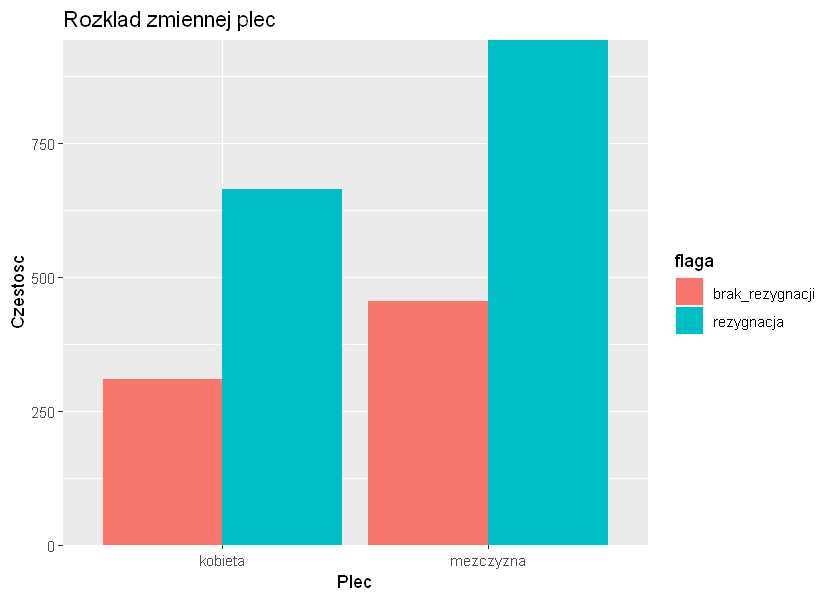

In [70]:
ggplot(dane, aes(x = Gender, fill = flaga)) +
  geom_bar(position="dodge") +
  labs(x = "Plec", y = "Czestosc", title = "Rozklad zmiennej plec") + 
  scale_y_continuous(expand = c(0,0))

In [71]:
liczba <- aggregate(dane$flaga, by=list(dane$Gender), FUN=length)
liczba <- cbind(liczba, liczba$x/2372)

liczba <- liczba %>%
  rename(
    plec = Group.1,
    liczebnosc=x,
    procent_odchodzacych="liczba$x/2372"
  )
print(liczba)

       plec liczebnosc procent_odchodzacych
1   kobieta        973            0.4102024
2 mezczyzna       1399            0.5897976


```
Procent osób , które zrezygnowały z pracy według płci wynosi w przypadku kobiet 42%, natomiast mężczyźni stanowią 59%,
co odpowiada za ponad połowę ogólnej populacji płci męskiej w firmie.
```

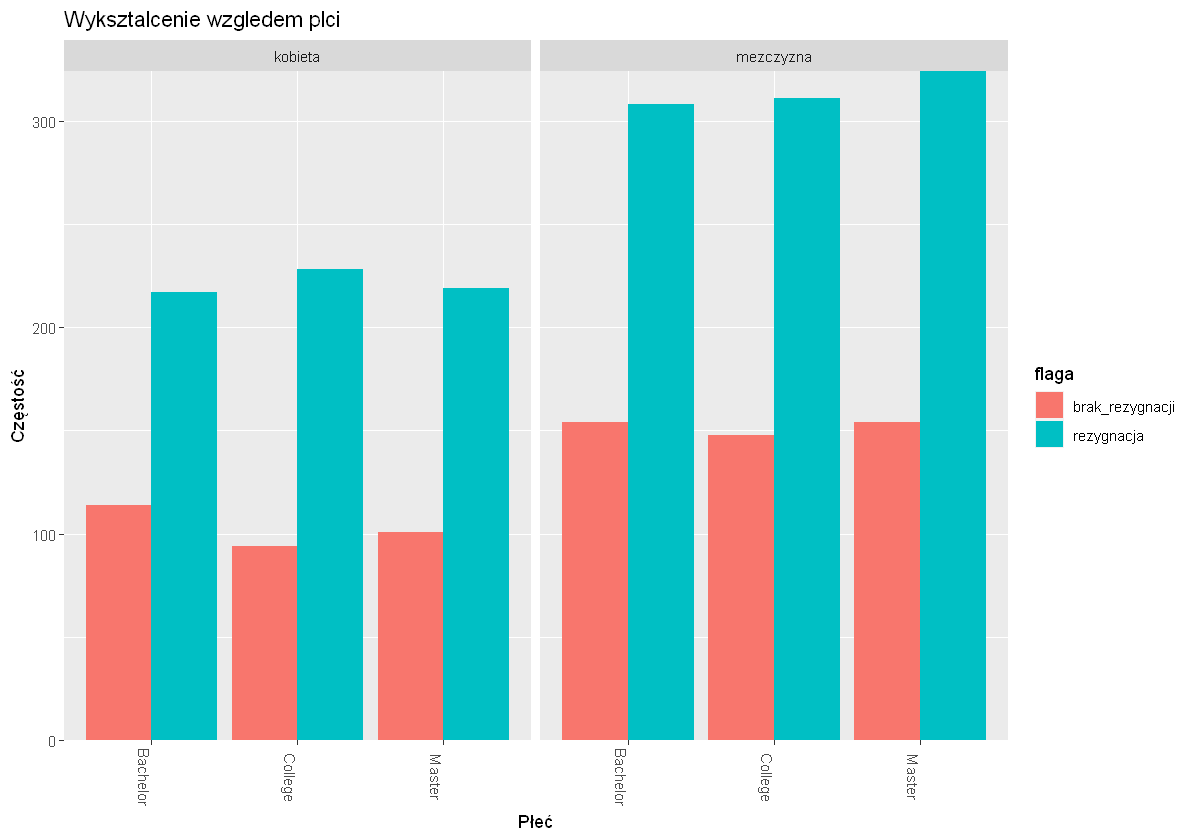

In [72]:
options(repr.plot.width=10, repr.plot.height=7)
ggplot(dane, aes(x = Education_Level, fill=flaga)) +
  geom_bar(position="dodge") +
  labs(x = "Płeć", y = "Częstość", title = "Wyksztalcenie wzgledem plci") + 
  scale_y_continuous(expand = c(0,0)) +
  theme(axis.text.x=element_text(angle=-90)) +
  facet_wrap(~Gender)

```
Rozstaw wykresów jest bardzo do siebie zbliżony - mężczyźni podobnie jak i kobiety, bez względu na poziom wykształcenia
podejmują podobne decyzję w sprawie rezygnacji z firmy.

Wspominając o wykształceniu naszych pracowników spójrzmy na zestawienie ze względu na rezygnację.
```

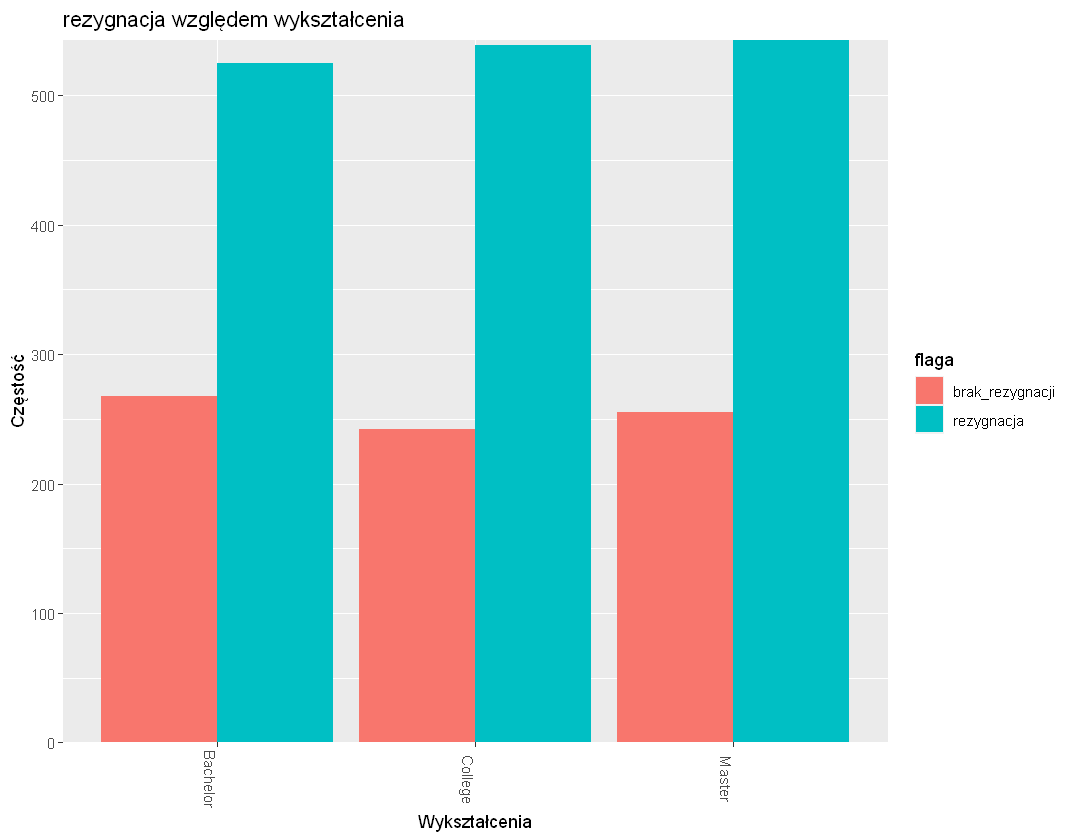

In [73]:
options(repr.plot.width=9, repr.plot.height=7)
ggplot(dane, aes(x = Education_Level, fill=flaga)) +
  geom_bar(position="dodge") +
  labs(x = "Wykształcenia", y = "Częstość", title = "rezygnacja względem wykształcenia") + 
  scale_y_continuous(expand = c(0,0)) +
  theme(axis.text.x=element_text(angle=-90))

```
Pomimo różnicy wykształcenia u pracowników, nie występują znaczące różnicę wśród osób rezygnujących z pracy, bądź 
wśród tych, którzy pozostają na swoim stanowisku.
```

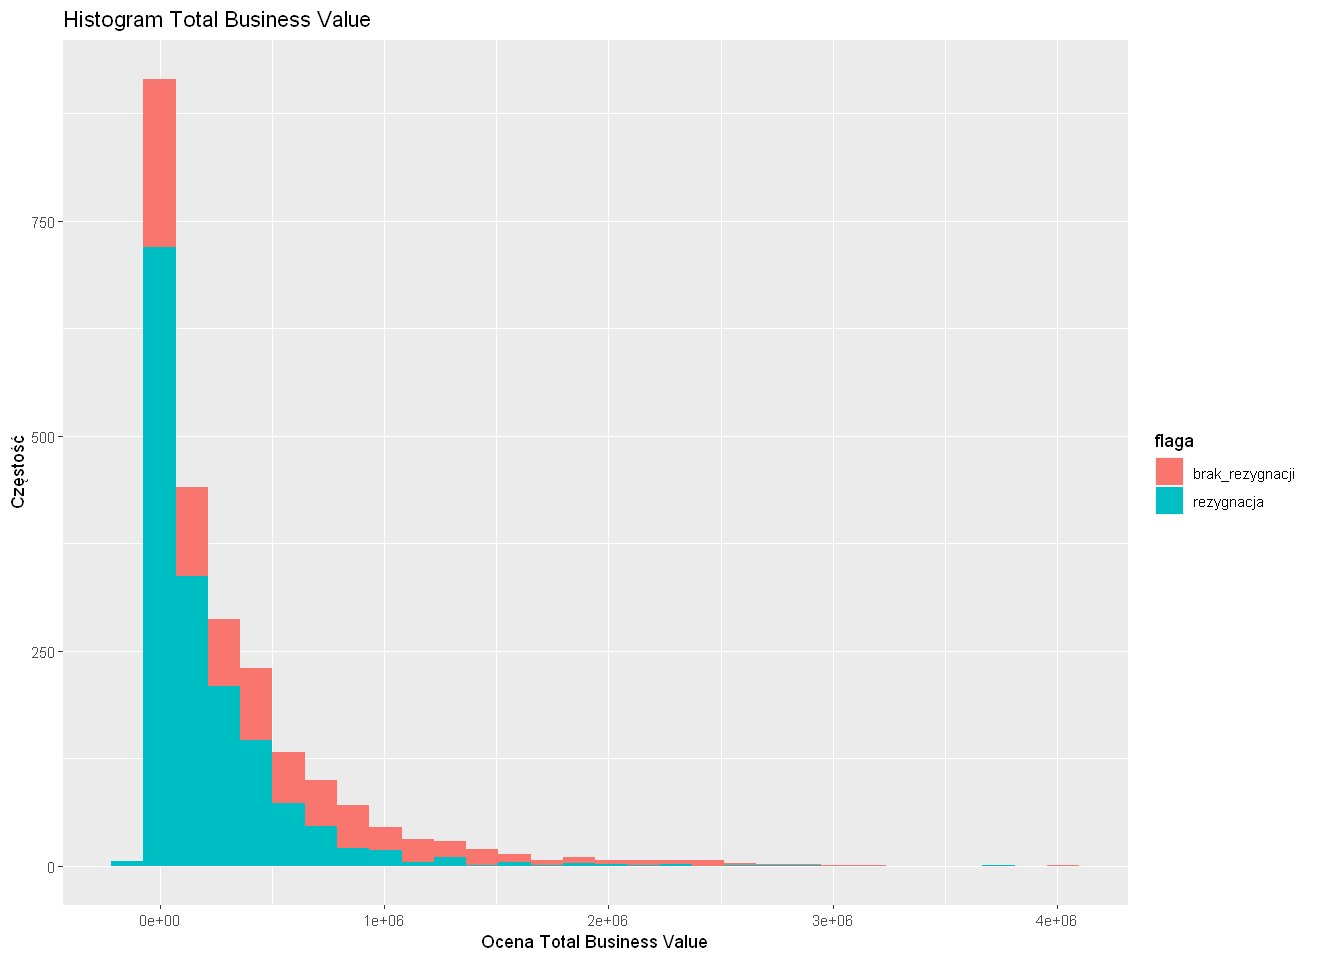

In [74]:
options(repr.plot.width=11, repr.plot.height=8)
ggplot(dane, aes(x = srednia_kpi, fill=flaga)) +
  geom_histogram(bins=30) +
  labs(x = "Ocena Total Business Value", y = "Częstość", title = "Histogram Total Business Value")

```
Możemy zauważyć zależność w obu grupach (rezygnacja z pracy oraz brak rezygnacji) - im większa wartość KPI tym większa
część słupka zajmują osoby, które nie odchodzą z pracy. Mówiąć w skrócie: rzadziej odchodzą z firmy osoby, które mają 
wyższe KPI.
```

```
Przyjrzyjmy się również sytuacji wiekowej w badanym miejscu pracy. Wygenerujmy następujące przedziały wiekowe:
- od 21 do 30 lat
- od 31 do 40 lat
- od 41 do 50 lat
- od 51 do 60 lat.
```

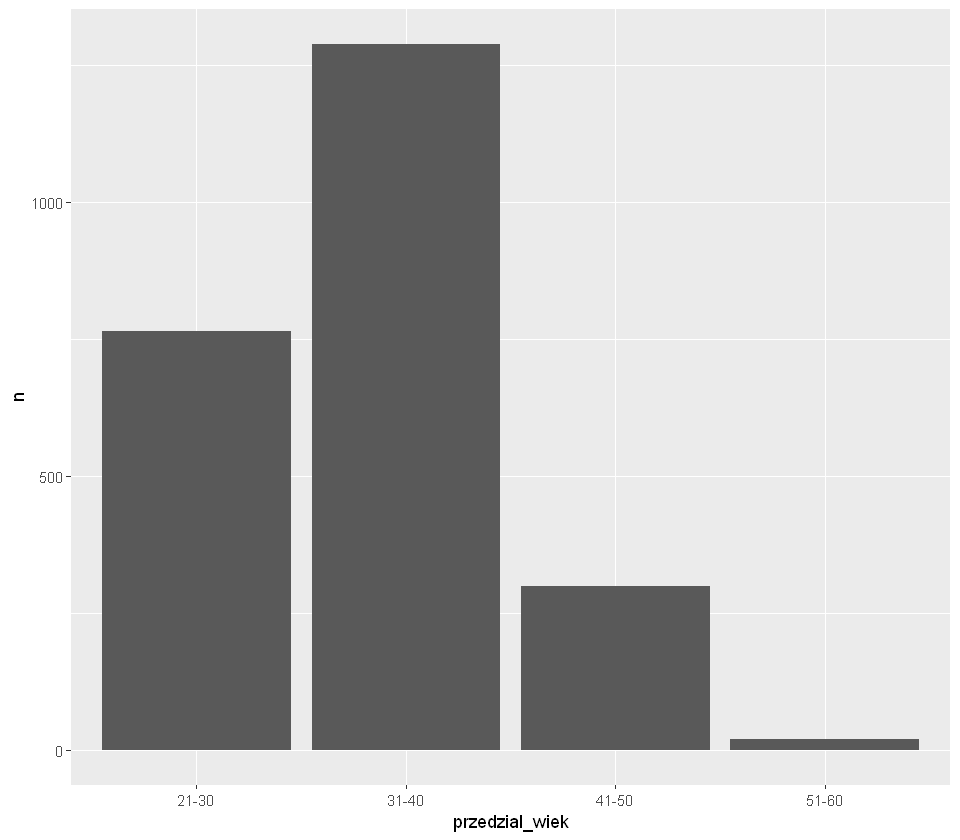

In [75]:
options(repr.plot.width=8, repr.plot.height=7)
dane$przedzial_wiek <-
  ifelse(
    dane$sredni_wiek <=30,'21-30',
    ifelse(
      dane$sredni_wiek <= 40, '31-40',
      ifelse(
        dane$sredni_wiek <= 50, '41-50',
        '51-60'
      )
    )
  )

dane %>% 
  group_by(przedzial_wiek) %>% 
  summarise(n= n()) %>% 
  ggplot(aes(x = przedzial_wiek, y = n)) +
  geom_col() 

```
Zdecydowana większość osób w firmie znajdowała się w przedziale między 31, a 40 rokiem życia. 
```

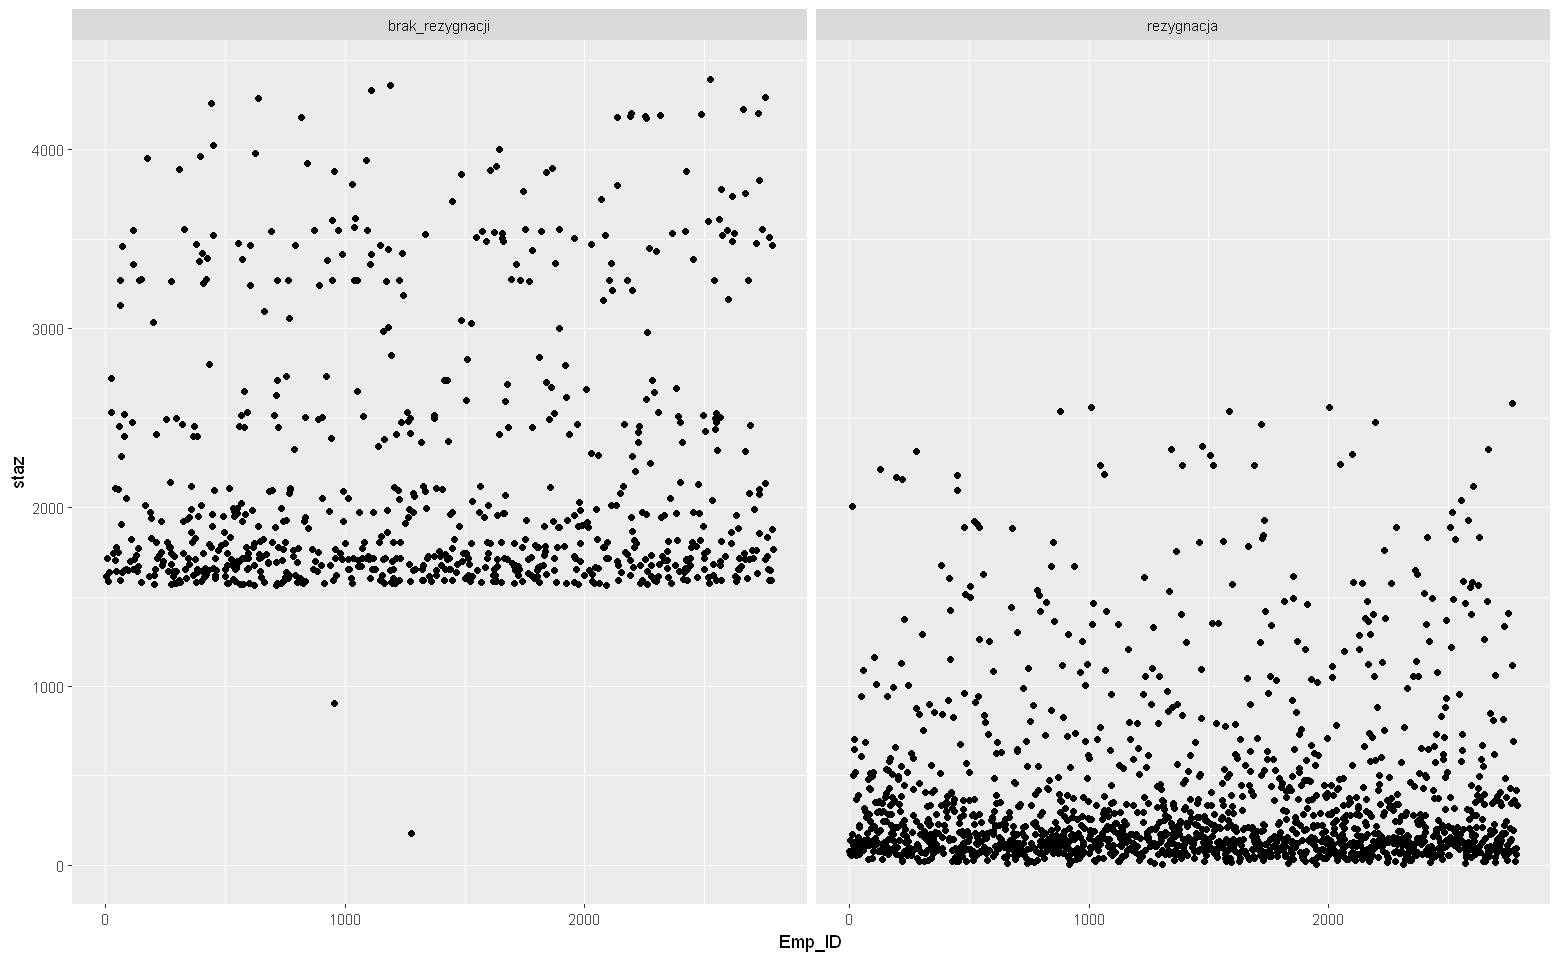

In [76]:
options(repr.plot.width=13, repr.plot.height=8)
ggplot(dane, aes(x = Emp_ID, y=staz)) + 
  geom_point() + 
  facet_wrap(~flaga)

```
Z analizy wykresów wynika, że osoby nieposiadające doświadczenia częściej rezygnowały z pracy, niż Ci, którzy
posiadali dłuższy staż w zawodzie. 

Skupmy uwagę na miasta, z których nasi pracownicy pochodzą. Mamy 29 miast z 19 stanów z USA. Możemy sprawdzić,
które miasto wyróżnia się na tle reszty.
```

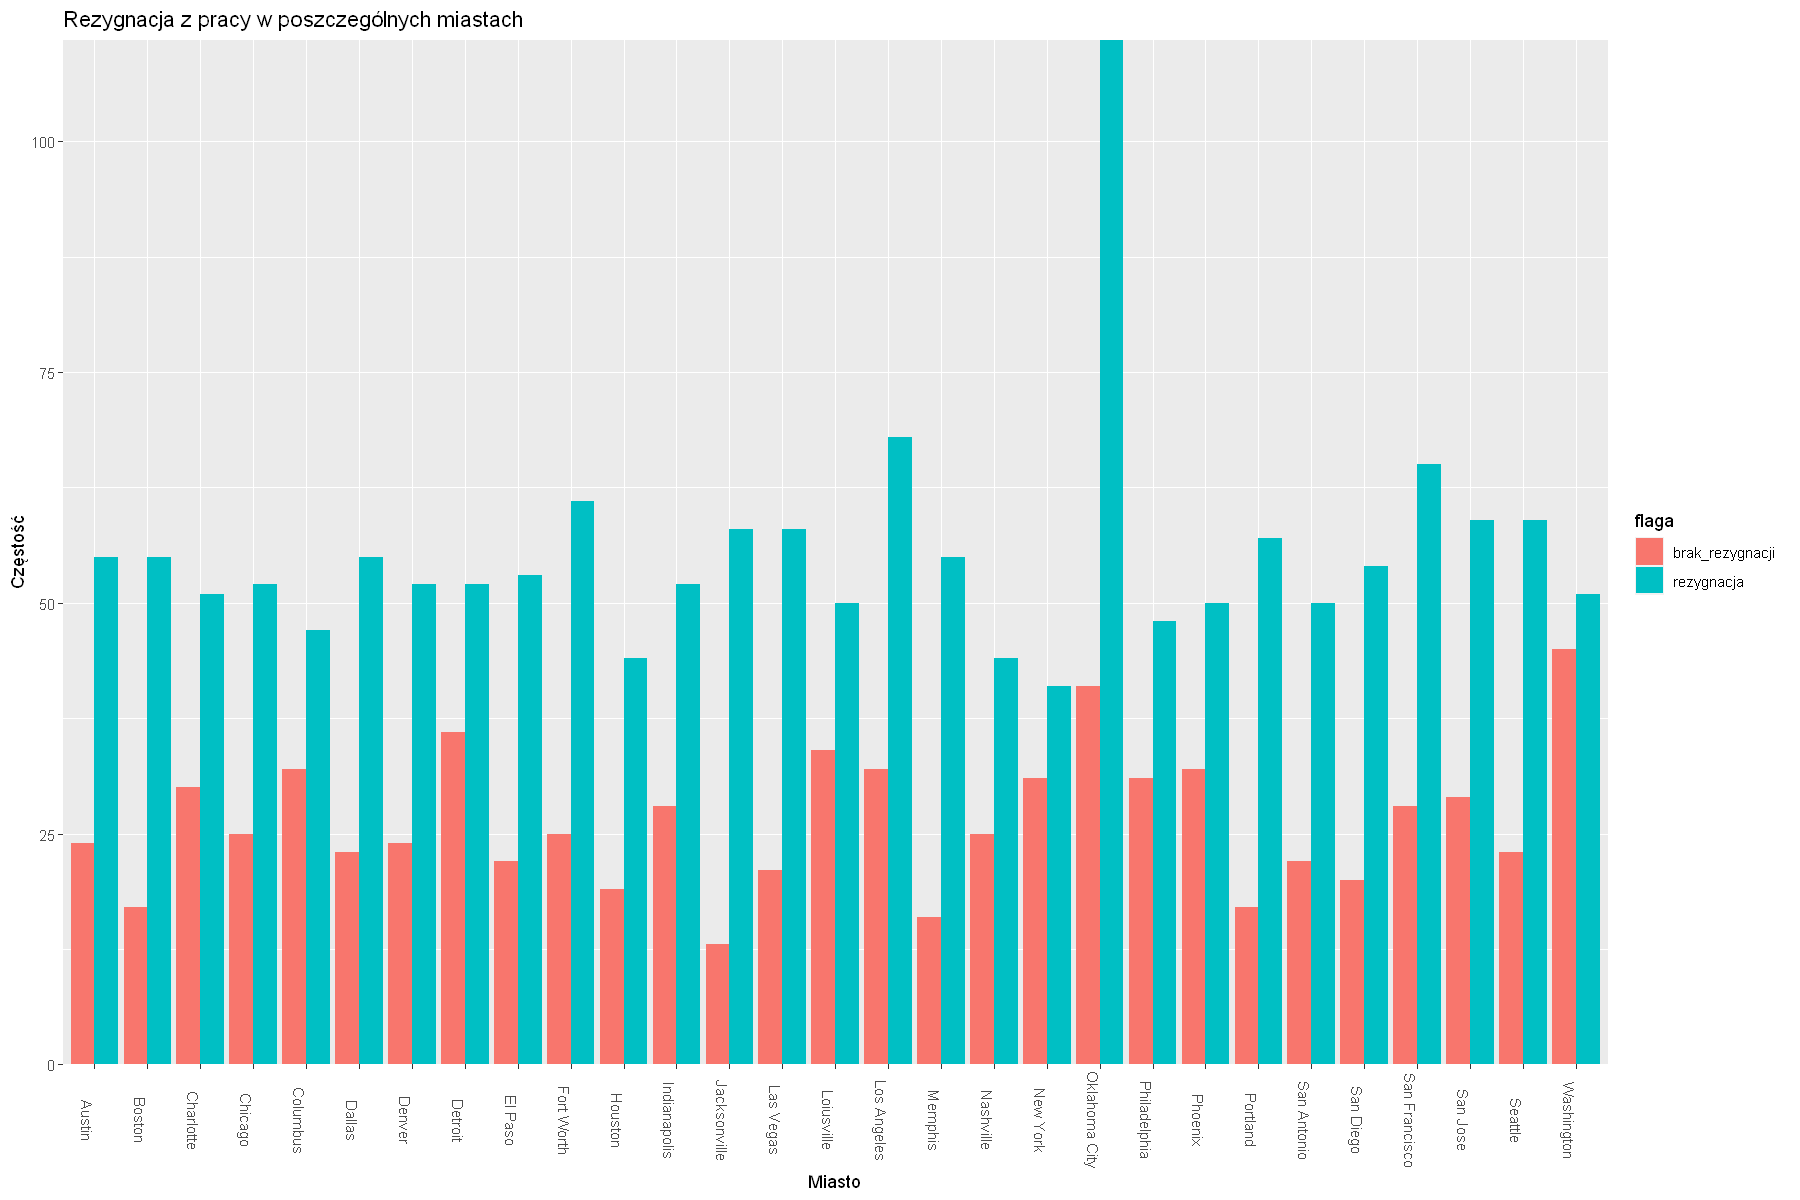

In [77]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(dane, aes(x = City_Name, fill = flaga)) +
  geom_bar(position="dodge") +
  labs(x = "Miasto", y = "Częstość", title = "Rezygnacja z pracy w poszczególnych miastach") + 
  theme(axis.text.x=element_text(angle=-90)) +
  scale_y_continuous(expand = c(0,0))

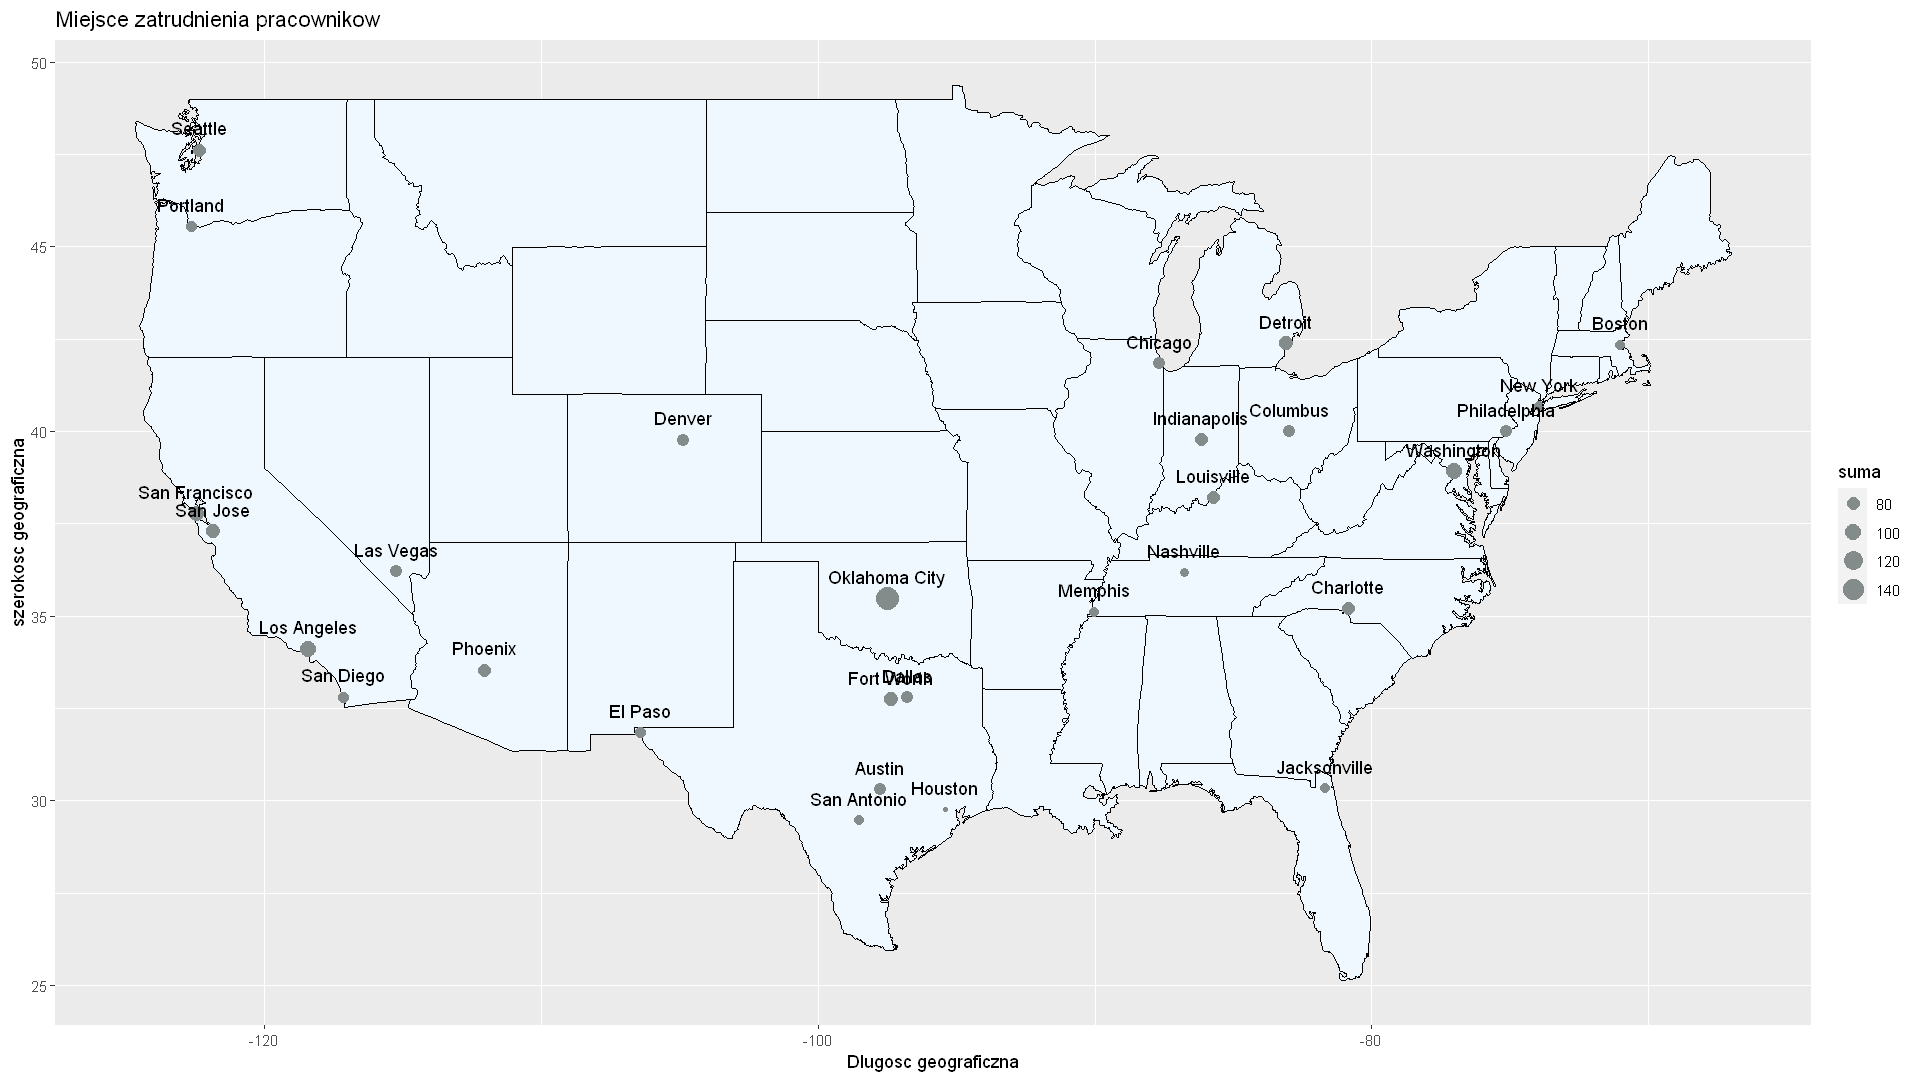

In [78]:
MainStates <- map_data("state")

zbior_danych <- read.csv('zbior_danych_czysty.csv')
dane_mapa <- zbior_danych[c('City_Name', 'Emp_ID'), ]
miasta_czyste$City_Name[miasta_czyste$City_Name == 'Loiusville'] <-
  'Louisville'
zbior_danych$City_Name[zbior_danych$City_Name == 'Loiusville'] <-
  'Louisville'
uscity <- us.cities

for (i in 1:length(uscity$name)) {
  uscity$name[i] <-
    substr(us.cities$name[i], 1, nchar(us.cities$name[i]) - 3)
}
uscity$name[uscity$name == 'WASHINGTON'] = 'Washington'
unikalne <- zbior_danych[!duplicated((zbior_danych$Emp_ID)), ]
dane_sum <- unikalne %>% group_by(City_Name) %>% summarise(n())

miasta_nazwy <-
  sqldf('SELECT * from miasta_czyste m inner join uscity u on m.City_Name = u.name')
miasta_nazwy <-
  miasta_nazwy[-c(5, 6, 16, 26), ]

names(dane_sum) <- c('City_name', 'suma')
zbior_danych$City_Name[zbior_danych$City_Name == 'Louisville'] <- 'Louisville'
dane_zagregowane <-
  sqldf(
    'SELECT distinct d.City_Name, ds.suma from zbior_danych d left join dane_sum ds on d.City_Name = ds.City_name'
  )
dane_nazwy_wspolrzedne <-
  sqldf(
    'select d.City_Name, d.suma, mn.lat, mn.long  from dane_zagregowane d left join miasta_nazwy mn on d.City_Name = mn.name'
  )

p <- ggplot() +
  geom_polygon(
    data = MainStates,
    aes(x = long, y = lat, group = group),
    color = "black",
    fill = "aliceblue"
  )

plot <-
  p + geom_point(data = dane_nazwy_wspolrzedne,
                 aes(x = long, y = lat, size = suma),
                 colour = "azure4") + scale_size(name = "suma") + geom_text(data = dane_nazwy_wspolrzedne, 
                aes(x = long, y = lat + 0.6, label = City_Name)) +
  labs(title = "Miejsce zatrudnienia pracownikow") + xlab("Dlugosc geograficzna") + ylab("szerokosc geograficzna")

options(repr.plot.width=16, repr.plot.height=9)
plot

```
Zdecydowanie naszą uwagę przyciąga miasto Oklahoma City. Możliwe, że w tym miejscu pojawiają się nieznane nam
problemy, powodujące tak częste odejścia pracowników pośród innych miast. Przeciwieństwem do Oklahoma City jest 
Waszyngton, gdzie poziom obu grup jest dosyć wyrównany.
```

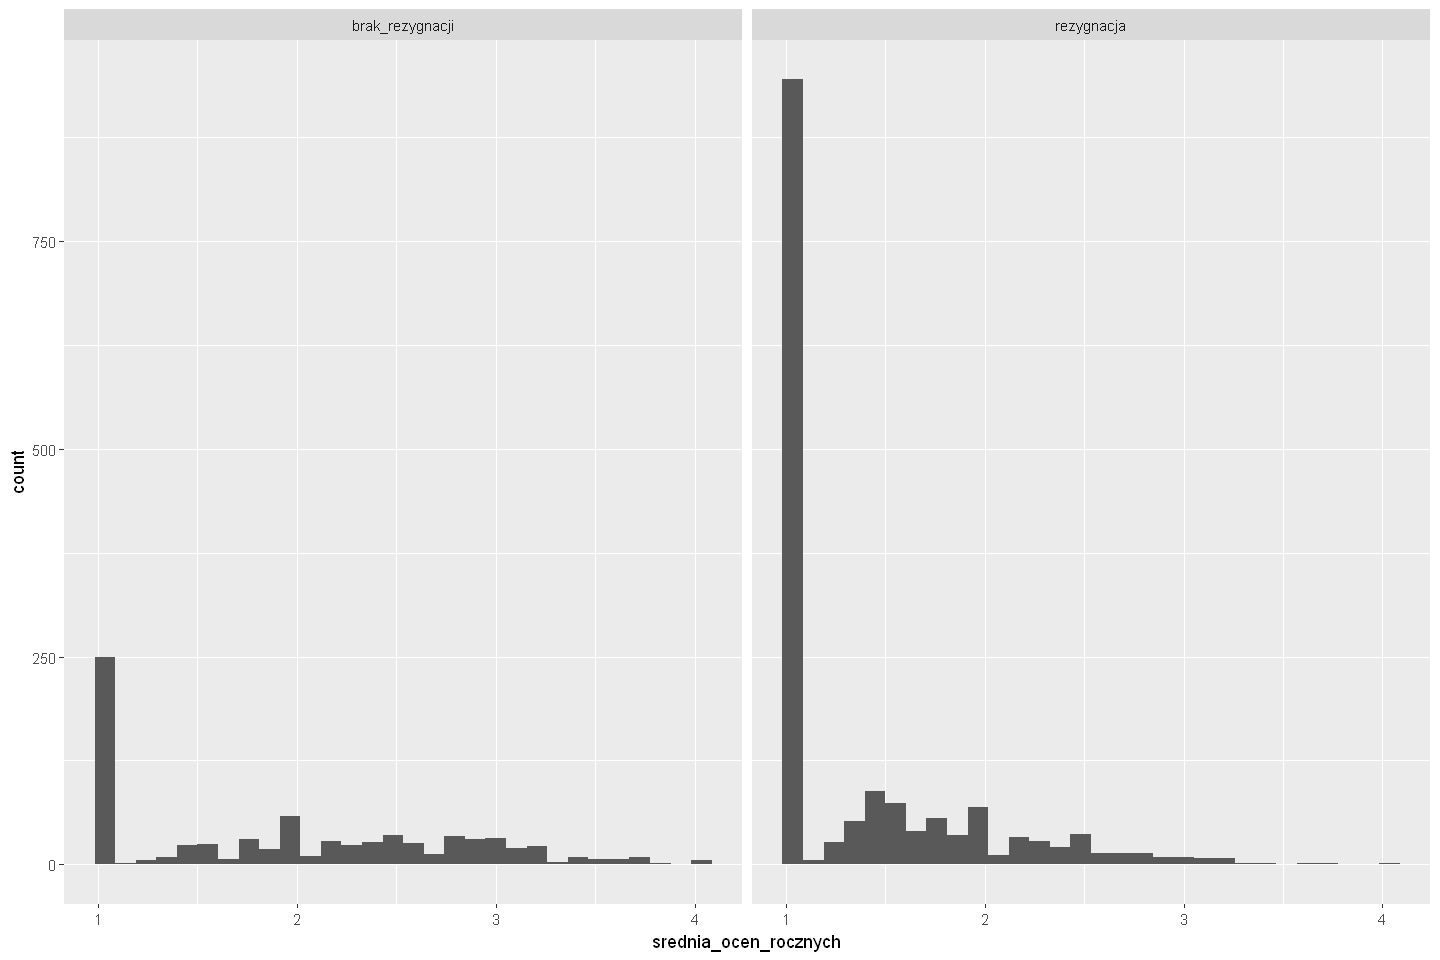

In [79]:
options(repr.plot.width=12, repr.plot.height=8)
ggplot(dane, aes(x=srednia_ocen_rocznych)) + 
  geom_histogram(bins=30) + 
  facet_wrap(~flaga)

```
W przypadku analizy ocen rocznych możemy spostrzec, iż osoby, które otrzymują oceny roczne na poziomie 1 znacznie 
częściej odchodzą z firmy, natomiast osoby pozostające na swoim stanowisku mają nieznacznie wyższe średnie oceny 
(pomijając oceny o wartości 1).
```

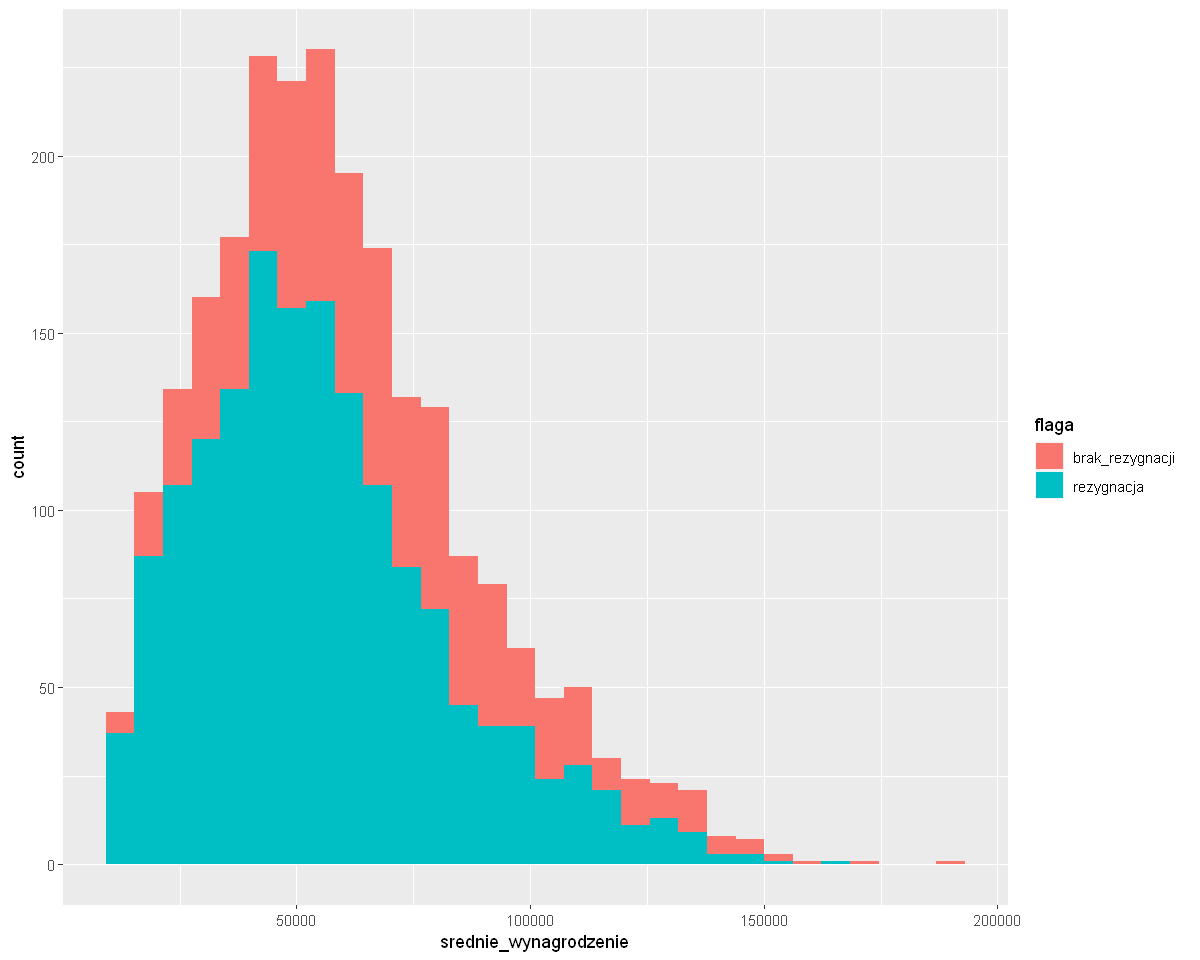

In [80]:
options(repr.plot.width=10, repr.plot.height=8)
ggplot(dane, aes(x=srednie_wynagrodzenie, fill=flaga)) + 
  geom_histogram(bins=30)

```
Analizując przedstawiony wykres wnioskujemy, iż pracownicy zarabiający przeciętnie więcej mają niższe ryzyko
opuszczenia miejsca pracy w porównaniu do tych, którzy zarabiają mniejsze średnie wynagrodzenie.
```